# Assignment 1 - EigenFaces

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [1]:
import cupy as np
import pandas as pd
import cv2 as cv
import glob
import matplotlib.pyplot as plt

In [2]:
# path if in local 
# path = './archive/s*'

# path if in colab
path = '/content/drive/MyDrive/Pattern/eigen-faces/archive/s*'

## 1. Download the Dataset and Understand the Format (10 Points)
## 2. Generate the Data Matrix and the Label vector (10 Points)

In [28]:
N = 10304
D = np.ones((1, N))

dirs = glob.glob(path)
y = np.array([])
j = 0
for i, dir in enumerate(dirs, 1):
    for f in glob.glob(dir+"/*"):
        img = cv.imread(f, 0)
        img = np.reshape(img, (1, N))
        D = np.append(D, img, axis=0)
        y = np.append(y, i)
        j+=1
        if j == 400:
          break

D = D[1:,]  # skip first row (1*N)


print(D.shape)
y = np.array(y)
print(y.shape)

(400, 10304)
(400,)


## 3. Split the Dataset into Training and Test sets (10 Points)

In [38]:
# training => odd
# testing => even
d_train, d_test = D[1::2], D[0::2]
y_train, y_test = y[1::2], y[0::2]


## 4. Classification using PCA (30 points)

In [6]:
d_train.shape

(200, 10304)

In [7]:
# compute mean
mean = np.mean(d_train,axis=0, keepdims=True)
print("Mean shape:", mean.shape)

# center data
Z = d_train - mean
print("Z shape:", Z.shape)

# compute covariance matrix
cov = np.cov(Z.T, bias=True)

# make sure covariance matrix is correct
# std = np.std(Z, axis=0)
# print("Covariance:", cov)
# print("Variance of each diagonal:", std * std)

# compute eigenvalues & eigenvectors
eival, eivec = np.linalg.eigh(cov)

# sort eigenval in descending order & corresponding eigenvec
# idx = np.argsort(eival)[::-1]
# eival = eival[idx]
# eivec = eivec[:,idx]

eival = eival[::-1]
eivec = eivec[:,::-1]

# add eigenvalues until explained variance >= alpha
eival_sum = np.sum(eival)

Mean shape: (1, 10304)
Z shape: (200, 10304)


In [64]:
del Z, cov

In [8]:
alphas = [0.8, 0.85, 0.9, 0.95]
proj_matrices = []
for alpha in alphas:
    # nominator of explained variance
    exp_var_nom = 0
    i = 0
    #while(round(exp_var_nom/float(eival_sum), 2) < alpha and i < len(eival)-1):
    while(exp_var_nom/float(eival_sum)) < alpha and i < len(eival)-1:
        exp_var_nom += eival[i]
        i += 1
    print(i-1)
    proj_matrix = eivec[:, :i] # here we don't need to add 1 to i, since we post increment it
    proj_matrices.append(proj_matrix)

36
51
75
115


In [65]:
del eivec, eival

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def classify_knn(data_train, labels_train, data_test, labels_test, k=1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data_train, labels_train)
    
    # we can calculate accuracy either way
    
    # labels_pred = knn.predict(data_test)
    #accuracy = metrics.accuracy_score(labels_test, labels_pred)
    
    accuracy = knn.score(data_test, labels_test)
    
    return accuracy

In [10]:
scores = {}

org_accuracy = classify_knn(d_train.get(), y_train.get(), d_test.get(), y_test.get(), k=1)
print("Original accuracy:", org_accuracy)

for proj_matrix, alpha in zip(proj_matrices, alphas):
    d_train_new = np.dot(d_train, proj_matrix)
    d_test_new = np.dot(d_test, proj_matrix)
    
    accuracy = classify_knn(d_train_new.get(), y_train.get(), d_test_new.get(), y_test.get(), k=1)
    scores[alpha] = accuracy
       
print("Accuracy for each alpha:", scores)


Original accuracy: 0.95
Accuracy for each alpha: {0.8: 0.955, 0.85: 0.945, 0.9: 0.955, 0.95: 0.95}


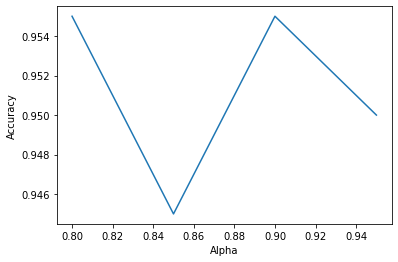

In [11]:
# Accuracy vs alpha

scores_plt = (scores.items())
x, y = zip(*scores_plt)
plt.plot(x, y)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

## 5. Classification using LDA (30 points)

In [39]:
# calculate class means
means = np.ones((40, N))

class_matrices = []

for i in range(40):
    class_matrix = d_train[i*5:(i+1)*5,:]
    mean = np.mean(class_matrix, axis=0, keepdims=True)
    means[i] = mean
    class_matrices.append(class_matrix)

overall_mean = np.mean(d_train, axis=0, keepdims=True)
#print(means)

In [40]:
# calculate between-class scatter matrix
nk = 5
Sb = np.zeros((N, N))
for i, mean in enumerate(means):
    mean = mean.reshape(N, 1)
    overall_mean = overall_mean.reshape(N, 1)
    Sb += nk * np.dot((mean - overall_mean), (mean - overall_mean).T)

In [41]:
# calculate center class matrics
Zs = []
for i in range(40):
    Z = class_matrices[i] - means[i]
    Zs.append(Z)

In [42]:
Ss = np.zeros((N,N))
print(Ss.shape)
# calculate class scatter matrices

for i in range(40):
    Si = np.dot(Zs[i].T,Zs[i])
    Ss +=Si
Ss_inv = np.linalg.inv(Ss)
w, v = np.linalg.eigh(np.dot(Ss_inv,Sb))

# using 39 dominant eigen vectors
# idx = w.argsort()[::-1][:39]
w = w[::-1]
v = v[:,::-1]

v = v[:,:40]

print(w.shape)
print(v.shape)


(10304, 10304)
(10304,)
(10304, 40)


In [43]:
def project(x, w):
    x = np.asarray(x)
    w = np.asarray(w)
    
    return np.dot(w,x.T).T
# print(v.shape)
d_train_new = project(d_train,v.T)
d_test_new = project(d_test,v.T)
print(d_train_new.shape)
print(d_test_new.shape)

accuracy = classify_knn(d_train_new.get(), y_train.get(), d_test_new.get(), y_test.get(), k=1)
print(f"accuracy: {accuracy}")

(200, 40)
(200, 40)
accuracy: 0.96


## 6. Classifier Tuning (20)

a. Set the number of neighbors in the K-NN classifier to 1,3,5,7.

**Tie breaking:**

* We left tie breaking to the default sklearn tie breaking strategy of KNeighborsClassifier

From the documentation for KNeighborsClassifier:

"Warning: Regarding the Nearest Neighbors algorithms, if it is found that two neighbors, neighbor k+1 and k, have identical distances but different labels, the results will depend on the ordering of the training data."

So, in the case of ties, the answer will be the class that happens to appear first in the set of neighbors.

### 6. 1 PCA Tuning

In [17]:
Ks = [1, 3, 5, 7]

scores = {}

for k in Ks:
    scores_per_k = {}
    for proj_matrix, alpha in zip(proj_matrices, alphas):
        d_train_new = np.dot(d_train, proj_matrix)
        d_test_new = np.dot(d_test, proj_matrix)
        accuracy = classify_knn(d_train_new.get(), y_train.get(), d_test_new.get(), y_test.get(), k=k)
        scores_per_k[alpha] = accuracy
    scores[k] = scores_per_k
    print("K =", k)
    print(scores[k])
    print("\n")


K = 1
{0.8: 0.955, 0.85: 0.945, 0.9: 0.955, 0.95: 0.95}


K = 3
{0.8: 0.905, 0.85: 0.905, 0.9: 0.9, 0.95: 0.88}


K = 5
{0.8: 0.82, 0.85: 0.83, 0.9: 0.835, 0.95: 0.805}


K = 7
{0.8: 0.75, 0.85: 0.745, 0.9: 0.735, 0.95: 0.73}




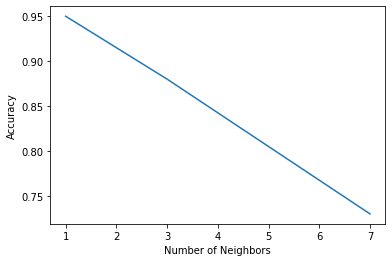

In [18]:
# plotting
max_accs = []

for k in scores:
    max_alpha = max(scores[k])
    max_acc = scores[k][max_alpha]
    max_accs.append(max_acc)
    
plt.plot(Ks, max_accs)
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

### 6.2 LDA Tuning

In [44]:
def project(x, w):
    x = np.asarray(x)
    w = np.asarray(w)
    
    return np.dot(w,x.T).T
# print(v.shape)
d_train_new_lda = project(d_train,v.T)
d_test_new_lda = project(d_test,v.T)
print(d_train_new_lda.shape)
print(d_test_new_lda.shape)


(200, 40)
(200, 40)


In [45]:
scores = {}
kk = []
Ks = [1, 3, 5, 7]

for k in Ks:
    scores_per_k = {}
    accuracy = classify_knn(d_train_new_lda.get(), y_train.get(), d_test_new_lda.get(), y_test.get(), k=k)
    print(f"accuracy: {accuracy}")
    scores[k] = accuracy
    kk.append(accuracy)
scores

accuracy: 0.96
accuracy: 0.925
accuracy: 0.885
accuracy: 0.825


{1: 0.96, 3: 0.925, 5: 0.885, 7: 0.825}

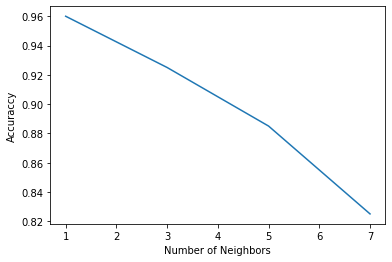

In [46]:
plt.plot(Ks,kk)
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuraccy")
plt.show()

## 7. Compare with Non-face images (15 points)

### Load Dataset

In [5]:
# Load non-faces equal in count to faces (200 train, 200 test)
# Labels: 1 --> Face, 0 --> Non-face

# if in local
# non_face_path = './non_faces' 

# if in colab
non_face_path = "/content/drive/MyDrive/Pattern/eigen-faces/non_faces"


N = 10304
d_non = np.ones((1, N))

y_non = np.array([])
i = 0
temp_img = np.array([92, 112])

for f in glob.glob(non_face_path+"/*"):
    if i == 400:
        break
    img = cv.imread(f, 0)
    temp_img = img[:92, :112]
    img = temp_img
    img = np.reshape(img, (1, N))
    d_non = np.append(d_non, img, axis=0)
    y_non = np.append(y_non, 0)
    i+=1

d_non = d_non[1:,]  # skip first row (1*N)


print(d_non.shape)
y_non = np.expand_dims(np.array(y_non), 1)
print(y_non.shape)

(400, 10304)
(400, 1)


In [6]:
y1 = np.ones((400,1))
print(y1.shape)

(400, 1)


In [7]:
# Non-face array w/ labels
non_faces = np.append(d_non, y_non, axis=1)
faces = np.append(D, y1, axis=1)
print(non_faces.shape)
print(faces.shape)

data = np.append(non_faces, faces, axis=0)
print(data.shape)
d2 = data[:, :N]
y2 = data[:,N]

print(d2.shape)
print(y2.shape)

(400, 10305)
(400, 10305)
(800, 10305)
(800, 10304)
(800,)


In [8]:
# separate into training & testing (one odd, one even)
# training => odd
# testing => even
d2_train, d2_test = d2[1::2], d2[0::2]
y2_train, y2_test = y2[1::2], y2[0::2]

print(d2_train.shape)

(400, 10304)


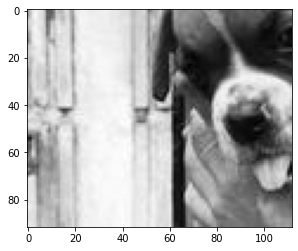

In [9]:
img = d2_train[120]
img = np.reshape(img, (92, 112))

plt.imshow(img.get(), cmap='gray')
plt.show()


### PCA

In [15]:
#!/usr/bin/env python
# coding: utf-8

# # Importing Libraries

# In[1]:


import cupy as np

class PCA():
    def __init__(self):
        # the percentage of the information that we need
        pass
        
        
    
    # get mean of every dimensions
    def get_mean(self):
        mean = np.mean(self.data, axis = 0, keepdims = True)
        self.mean = mean
        del mean
        
#         return mean
    
    
    # Center data around the mean
    def center_data(self):
        self.c_data = self.data - self.mean
        del self.data
        del self.mean
        
#         return self.data
    
    
    # get covairance matrix of the data
    def cov(self):
        self.cov = np.cov(self.c_data.T, bias = True)
        del self.c_data
        
#         return self.cov
    
    
    
    # calculate eigen values and eigen vector
    # centralized
    def calc_eig(self):
        w, v = np.linalg.eigh(self.cov)
        w = w[::-1]
        v = v[:,::-1]
        
        self.eival = w
        self.eivec = v
        self.eival_sum = np.sum(w)
        

    # get projected matrix which contains the new dimensions
    def calc_proj_matrix(self):
        
        eival_sum = self.eival_sum
        alpha = self.alpha
        eival = self.eival
        eivec = self.eivec
        
        exp_var_nom = 0
        i = 0
        while exp_var_nom/float(eival_sum) < alpha and i < len(eival)-1:
            exp_var_nom += eival[i]
            i += 1
        print(i-1)
        self.proj_matrix = eivec[:, :i]
        print(i)
#         return self.proj_matrix
              
    def get_proj_matrix(self):
        return self.proj_matrix
    
    def _fit(self, data):
        self.data = data
        # get mean matrix
        self.get_mean()
        # center data around mean
        self.center_data()
        # get covariance matrix
        self.cov()
        # get eigvals ,eigvecs
        self.calc_eig()

    
    def fit(self, data):
        self.calc_proj_matrix()
        
    def transform(self, X):
        return np.dot(X,self.proj_matrix)
    
    def set_alpha(self, alpha):
        self.alpha = alpha    
        



In [67]:
alphas = [0.8, 0.85, 0.9, 0.95]
scores = {}
pca = PCA()
pca._fit(d2_train.get())
print("Done fitting!")

Done fitting!


In [68]:
for alpha in alphas:
    pca.set_alpha(alpha)
    pca.fit(d2_train)
    d2_train_new = pca.transform(d2_train)
    d2_test_new = pca.transform(d2_test)
    
    accuracy = classify_knn(d2_train_new.get(), y2_train.get(), d2_test_new.get(), y2_test.get(), k=1)
    scores[alpha] = accuracy
    
scores

33
34
50
51
77
78
131
132


{0.8: 0.9933333333333333,
 0.85: 0.9933333333333333,
 0.9: 0.9933333333333333,
 0.95: 0.9966666666666667}

### LDA

In [10]:
import cupy as np

class LDA():
    def __init__(self, n_components=2):
        np.get_default_memory_pool().free_all_blocks()
        self.n_components = n_components

    def fit(self, X, y):
        class_labels = np.unique(y)  # should be of size 2

        d1 = X[y == class_labels[0]]
        d2 = X[y == class_labels[1]]
        #         print(f"D1 shape: {d1.shape}")
        #         print(f"D2 shape: {d2.shape}")

        mean1 = np.mean(d1, axis=0)
        mean2 = np.mean(d2, axis=0)

        diff = mean1 - mean2
        Sb = np.dot(diff, diff.T)
        
        del diff

        z1 = d1 - mean1.T
        z2 = d2 - mean2.T

        del mean1, mean2
        del d1, d2

        s1 = np.dot(z1.T, z1)
        s2 = np.dot(z2.T, z2)

        del z1, z2

        Sw = s1 + s2
        S_inv = np.linalg.inv(Sw)

        del Sw

        x = np.dot(S_inv, Sb)
        print(x.shape)

        del S_inv
        del Sb
        eigVal, eigVec = np.linalg.eigh(x)

        idxs = np.argsort(eigVal)[::-1]
        eigVal = eigVal[idxs]
        eigVec = eigVec[idxs]

        self.lin_discriminants = eigVec[:39]

    def get_lin_discriminants(self):
        return self.lin_discriminants

    def transform(self, X):
        res = np.dot(X, self.lin_discriminants.T)

        return res

In [11]:
np.get_default_memory_pool().free_all_blocks()
scores_lda = []
lda = LDA(2)


mempool = np.get_default_memory_pool()
pinned_mempool = np.get_default_pinned_memory_pool()
pinned_mempool.free_all_blocks()
mempool.free_all_blocks()
print(mempool.used_bytes())            
print(mempool.total_bytes())
print(pinned_mempool.n_free_blocks())


lda.fit(d2_train,y2_train)
print("Done fitting!")

198026240
198026240
0
(10304, 10304)
Done fitting!


In [12]:
d2_train_new_lda = lda.transform(d2_train)
d2_test_new_lda = lda.transform(d2_test)
accuracy = classify_knn(d2_train_new_lda.get(), y2_train.get(), d2_test_new_lda.get(), y2_test.get(), k=1)

accuracy

0.965

### Accuracy vs. Number of non-face images

In [13]:
# Plot the accuracy vs the number of non-face images while fixing 
# the number of face images.

# 50-50 Training so # of training samples = # testing samples

# number to try:
numbers = [200, 300, 400, 500, 600, 700]
datasets_train = {}
datasets_test = {}
ys_train = {}
ys_test = {}

# Reload data 

for num in numbers:
    d_non = np.ones((1, N))
    y_non = np.array([])
    i = 0
    temp_img = np.array([92, 112])
    for f in glob.glob(non_face_path+"/*"):
        if i == num:
            break
        img = cv.imread(f, 0)
        temp_img = img[:92, :112]
        img = temp_img
        img = np.reshape(img, (1, N))
        d_non = np.append(d_non, img, axis=0)
        y_non = np.append(y_non, 0)
        i+=1

    d_non = d_non[1:,]  # skip first row (1*N)
    y_non = np.expand_dims(np.array(y_non), 1)
    y1 = np.ones((400,1))
    # put faces & non faces together
    non_faces = np.append(d_non, y_non, axis=1)
    faces = np.append(D, y1, axis=1)

    data = np.append(non_faces, faces, axis=0)
    d2 = data[:, :10304]
    y2 = data[:,10304]
    
    d2_train, d2_test = d2[1::2], d2[0::2]
    y2_train, y2_test = y2[1::2], y2[0::2]
    
    datasets_train[num] = d2_train
    datasets_test[num] = d2_test
    ys_train[num] = y2_train
    ys_test[num] = y2_test
    


In [19]:
# USE CONSTANT ALPHA FOR PCA = 0.95

alpha = 0.95
pca_accuracies = {}
lda_accuracies = {}

for num in numbers:
    d2_train = datasets_train[num]
    d2_test = datasets_test[num]
    y2_train = ys_train[num]
    y2_test =  ys_test[num]
    
    pca = PCA()
    pca._fit(d2_train)
    pca.set_alpha(alpha)
    pca.fit(d2_train)
    d2_train_new = pca.transform(d2_train)
    d2_test_new = pca.transform(d2_test)
    
    accuracy = classify_knn(d2_train_new.get(), y2_train.get(), d2_test_new.get(), y2_test.get(), k=1)
    pca_accuracies[num] = accuracy
    
    
    lda = LDA(2)
    lda.fit(d2_train,y2_train)
    d2_train_lda_new = lda.transform(d2_train)
    d2_test_lda_new = lda.transform(d2_test)
    
    accuracy = classify_knn(d2_train_lda_new.get(), y2_train.get(), d2_test_lda_new.get(), y2_test.get(), k=1)
    lda_accuracies[num] = accuracy

print(pca_accuracies)
print(lda_accuracies)

131
132
(10304, 10304)
140
141
(10304, 10304)
150
151
(10304, 10304)
155
156
(10304, 10304)
164
165
(10304, 10304)
177
178
(10304, 10304)
{200: 0.9966666666666667, 300: 0.9971428571428571, 400: 0.9975, 500: 0.9977777777777778, 600: 0.998, 700: 0.9981818181818182}
{200: 0.9633333333333334, 300: 0.9571428571428572, 400: 0.965, 500: 0.9622222222222222, 600: 0.972, 700: 0.9618181818181818}


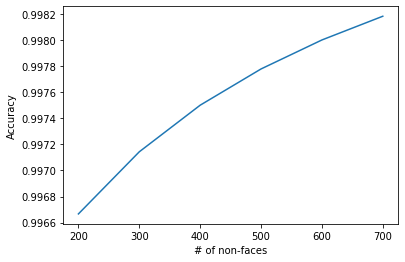

In [22]:
pca_plt = (pca_accuracies.items())
x1, y1 = zip(*pca_plt)
plt.plot(x1, y1)
plt.xlabel("# of non-faces")
plt.ylabel("Accuracy")
plt.show()

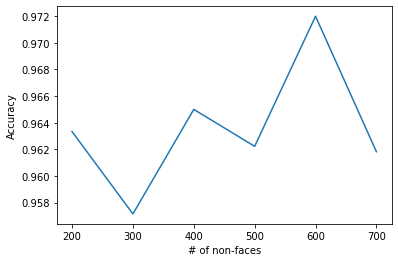

In [23]:
lda_plt = (lda_accuracies.items())
x2, y2 = zip(*lda_plt)
plt.plot(x2, y2)
plt.xlabel("# of non-faces")
plt.ylabel("Accuracy")
plt.show()

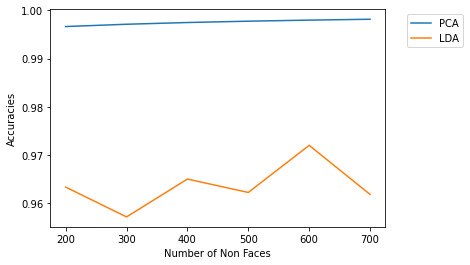

In [24]:
plt.xlabel("Number of Non Faces")
plt.ylabel("Accuracies")
plt.plot(x1,y1, label="PCA")
plt.plot(x2,y2, label="LDA")

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

### Observations:

PCA performs better in case where number of samples per class is less. Whereas LDA works better with large dataset having multiple classes; class separability is an important factor while reducing dimensionality.

This means, in the first task, LDA performed slightly better since there were 40 classes, but in the second task, PCA was visibly better.

## 8. Bonus (5 points)

### FACES CLASSIFICATION:

We have 400 faces. We take the first 7 instances of each class for training and the last 3 for testing.

In [29]:
D.shape, y.shape

((400, 10304), (400,))

In [30]:
d3_test = np.ones((1, N))
d3_train = np.ones((1, N))
y3_train = np.array([])
y3_test = np.array([])
for i in range(len(D)):
    stri = str(i)
    unit = stri[-1]
    if unit == '7' or unit == '8' or unit == '9':
        d3_test = np.append(d3_test, D[[i]], axis=0)
        y3_test = np.append(y3_test, y[i])
    else:
        d3_train = np.append(d3_train, D[[i]], axis=0)
        y3_train = np.append(y3_train, y[i])
        
        
d3_train = d3_train[1:,] 
d3_test = d3_test[1:,] 
        
print(d3_train.shape)
print(d3_test.shape)
print(y3_train.shape)
print(y3_test.shape)

(280, 10304)
(120, 10304)
(280,)
(120,)


### PCA:

In [31]:
alphas = [0.8, 0.85, 0.9, 0.95]
scores = {}
pca = PCA()
pca._fit(d3_train)
print("Done fitting!")

Done fitting!


In [33]:
for alpha in alphas:
    pca.set_alpha(alpha)
    pca.fit(d3_train)
    d3_train_new = pca.transform(d3_train)
    d3_test_new = pca.transform(d3_test)
    
    accuracy = classify_knn(d3_train_new.get(), y3_train.get(), d3_test_new.get(), y3_test.get(), k=1)
    scores[alpha] = accuracy
    
scores

40
41
59
60
92
93
148
149


{0.8: 0.9583333333333334,
 0.85: 0.9583333333333334,
 0.9: 0.9666666666666667,
 0.95: 0.9666666666666667}

### LDA:

In [34]:
means = np.ones((40, N))

class_matrices = []

for i in range(40):
    class_matrix = d3_train[i*5:(i+1)*5,:]
    mean = np.mean(class_matrix, axis=0, keepdims=True)
    means[i] = mean
    class_matrices.append(class_matrix)

overall_mean = np.mean(d3_train, axis=0, keepdims=True)

nk = 5
Sb = np.zeros((N, N))
for i, mean in enumerate(means):
    mean = mean.reshape(N, 1)
    overall_mean = overall_mean.reshape(N, 1)
    Sb += nk * np.dot((mean - overall_mean), (mean - overall_mean).T)

# calculate center class matrics
Zs = []
for i in range(40):
    Z = class_matrices[i] - means[i]
    Zs.append(Z)

Ss = np.zeros((N,N))
print(Ss.shape)
# calculate class scatter matrices

for i in range(40):
    Si = np.dot(Zs[i].T,Zs[i])
    Ss +=Si
Ss_inv = np.linalg.inv(Ss)
w, v = np.linalg.eigh(np.dot(Ss_inv,Sb))

# using 39 dominant eigen vectors
# idx = w.argsort()[::-1][:39]
w = w[::-1]
v = v[:,::-1]

v = v[:,:40]

print(w.shape)
print(v.shape)


(10304, 10304)
(10304,)
(10304, 40)


In [35]:
def project(x, w):
    x = np.asarray(x)
    w = np.asarray(w)
    
    return np.dot(w,x.T).T
# print(v.shape)
d3_train_new_lda = project(d3_train,v.T)
d3_test_new_lda = project(d3_test,v.T)
print(d3_train_new_lda.shape)
print(d3_test_new_lda.shape)

accuracy = classify_knn(d3_train_new_lda.get(), y3_train.get(), d3_test_new_lda.get(), y3_test.get(), k=1)

accuracy

(280, 40)
(120, 40)


0.9583333333333334